In [40]:
# handling BAG
import h5py
from io import BytesIO, StringIO

from lxml import etree

import xml.etree.ElementTree as ET

import numpy as np

import rasterio
from rasterio import features

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## awkward hack to import local modules in Jupyter
import sys
sys.executable
sys.path.append('/mnt/bigdata/frontierSI/qa4mbes-data-pipeline/qa4mbes')
import json
import geojson

In [3]:
def getbagcrs(metadata):
    #with help from Alex Leith
    
    root = ET.fromstring(metadata)
    #root = tree.getroot()

    namespaces = {
        'gmd': "http://www.isotc211.org/2005/gmd",
        'gco': "http://www.isotc211.org/2005/gco"
    }

    referencesystem = root.find('gmd:referenceSystemInfo', namespaces)[0]

    referencesystemid = referencesystem.find('gmd:referenceSystemIdentifier', namespaces).find('gmd:RS_Identifier', namespaces)

    crswkt = referencesystemid.find('gmd:code', namespaces).find('gco:CharacterString', namespaces).text
    
    if crswkt != '':
        epsgcode = rasterio.crs.CRS.to_epsg(rasterio.crs.CRS.from_string(crswkt))
        return epsgcode

In [11]:
bag = h5py.File('../../bag-samples/grid0_ellipsoid_1m.bag')

In [12]:
bag

<HDF5 file "grid0_ellipsoid_1m.bag" (mode r+)>

In [13]:
root = bag['BAG_root']

In [14]:
metadata = root['metadata']
elevation = root["elevation"]

In [15]:
metadata.value

array([b'<', b'?', b'x', ..., b'>', b'\n', b''], dtype='|S1')

In [16]:
buffer = BytesIO(metadata.value[:-1])

In [17]:
buffer.getvalue()

b'<?xml version="1.0" encoding="UTF-8"?>\n<gmi:MI_Metadata xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:bag="http://www.opennavsurf.org/schema/bag"><gmd:fileIdentifier><gco:CharacterString>86e1f452-89d0-4db0-a5a7-da6312db412e</gco:CharacterString></gmd:fileIdentifier><gmd:language><gmd:LanguageCode codeList="http://www.loc.gov/standards/iso639-2/" codeListValue="eng">eng</gmd:LanguageCode></gmd:language><gmd:characterSet><gmd:MD_CharacterSetCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#MD_CharacterSetCode" codeListValue="utf8">utf8</gmd:MD_CharacterSetCode></gmd:characterSet><gmd:hierarchyLevel><gmd:MD_ScopeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="datase

In [18]:
metadatastring = buffer.getvalue().decode()

In [19]:
this = getbagcrs(metadatastring)

In [20]:
elev = elevation.value

In [21]:
bag.close()

In [22]:
elev.min()

-71.85854

In [23]:
elev.max()

1000000.0

In [24]:
mask = elev

In [25]:
mask[:]=0

In [26]:
mask[mask >= elev.max()] = 0

In [27]:
np.nanmax(elev)

0.0

In [28]:
np.nanmin(elev)

0.0

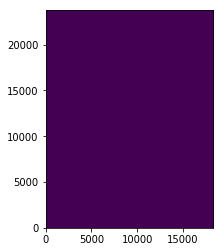

In [29]:

fig, ax = plt.subplots(1, 1)
ax.imshow(elev)
ax.invert_yaxis()



In [30]:
elev[10000][5001]

0.0

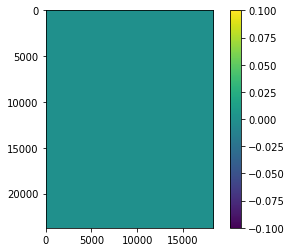

In [31]:

plt.imshow(mask)
plt.colorbar()

In [32]:
bag.close()

In [33]:
this

32755

In [34]:
dataset = rasterio.open('../../bag-samples/grid0_ellipsoid_1m.bag')

In [35]:
dataset.crs

CRS({'init': 'epsg:32755'})

In [36]:
dataset.bounds

BoundingBox(left=502809.4999727074, bottom=5630949.499978939, right=521131.5000272926, top=5654691.500021062)

In [38]:
dataset.read_masks()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [41]:
boundaries = features.shapes(dataset.dataset_mask(), transform=dataset.transform)

In [42]:
listofpolygons = [shape(bound[0]) for bound in boundaries]

NameError: name 'shape' is not defined

In [ ]:
multipoly = cascaded_union(listofpolygons[:-1])

In [ ]:
multipoly.boundary